In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/text-classification-int20h/submission.csv
/kaggle/input/text-classification-int20h/train.csv
/kaggle/input/text-classification-int20h/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/text-classification-int20h/train.csv')
test = pd.read_csv('/kaggle/input/text-classification-int20h/test.csv')
submission = pd.read_csv('/kaggle/input/text-classification-int20h/submission.csv')

# Simple EDA

In [3]:
print('train:', train.shape, 'test:', test.shape)
train.head()

train: (39582, 3) test: (10000, 2)


,id,review,sentiment
0,0,Action & Adventure.Billie Clark is twenty year...,1
1,1,I found this early talkie difficult to watch a...,0
2,2,It was Libby talking to Desmond in the flashba...,1
3,3,We fans of Ed Wood tend to be an obsessive bun...,1
4,4,"Hmm, Hip Hop music to a period western. Modern...",0


**Number of characters in texts**

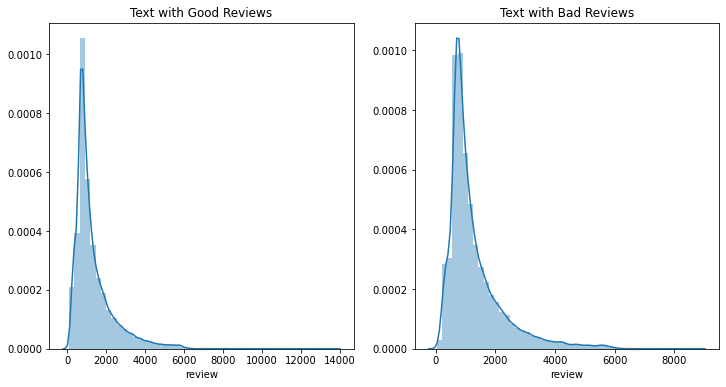

In [4]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.distplot(train[train.sentiment==1].review.str.len(), ax=ax1)
ax1.set_title('Text with Good Reviews')
sns.distplot(train[train.sentiment==0].review.str.len(), ax=ax2)
ax2.set_title('Text with Bad Reviews')
plt.show()

**Number of words in text**

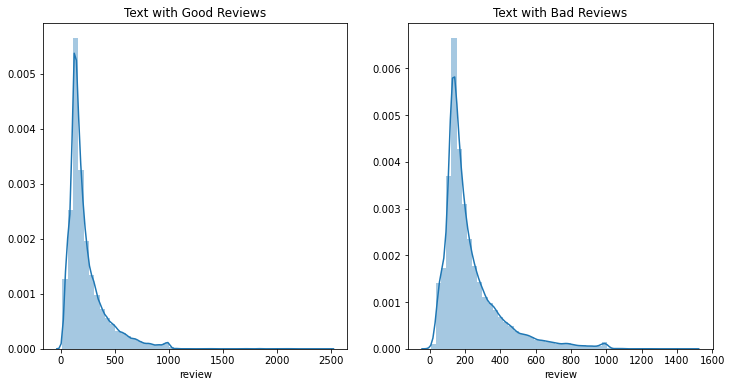

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.distplot(train[train.sentiment==1].review.str.split().map(lambda x: len(x)), ax=ax1)
ax1.set_title('Text with Good Reviews')
sns.distplot(train[train.sentiment==0].review.str.split().map(lambda x: len(x)), ax=ax2)
ax2.set_title('Text with Bad Reviews')
plt.show()

Note that word and character distributions are quite similar, with a long right tail. But this means that there are very long reviews, so pay attention, because most models process strings of a small length.

**Wordcloud for positive text**

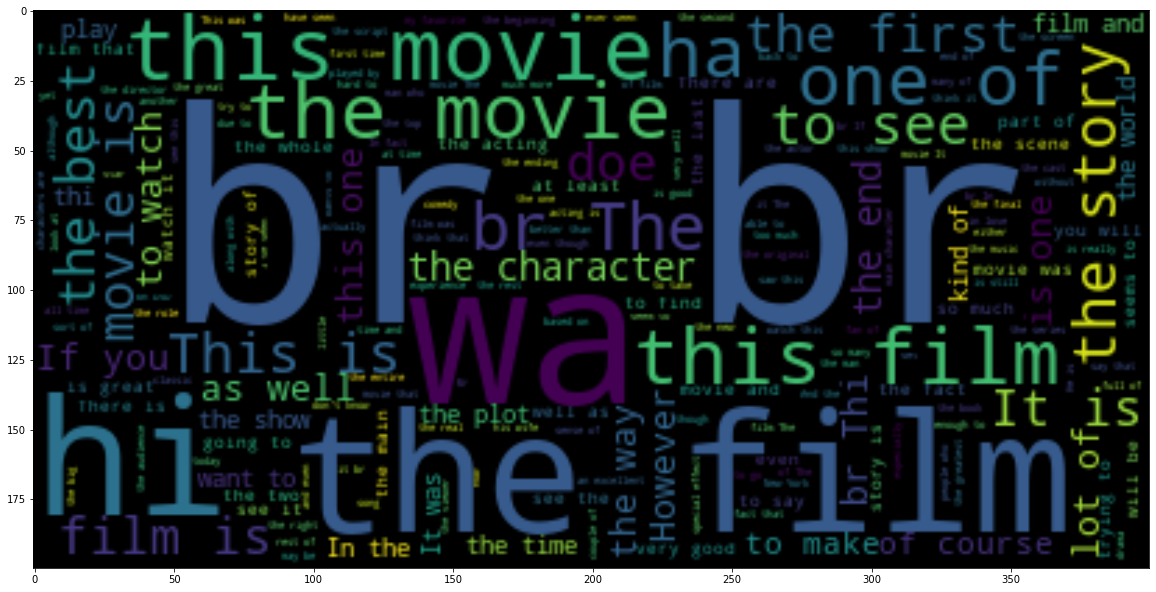

In [6]:
plt.figure(figsize = (20,20))
wc_positive = WordCloud(max_words = 1000).generate(" ".join(train[train.sentiment == 1].review))
plt.imshow(wc_positive , interpolation = 'bilinear')

**Wordcloud for negative text**

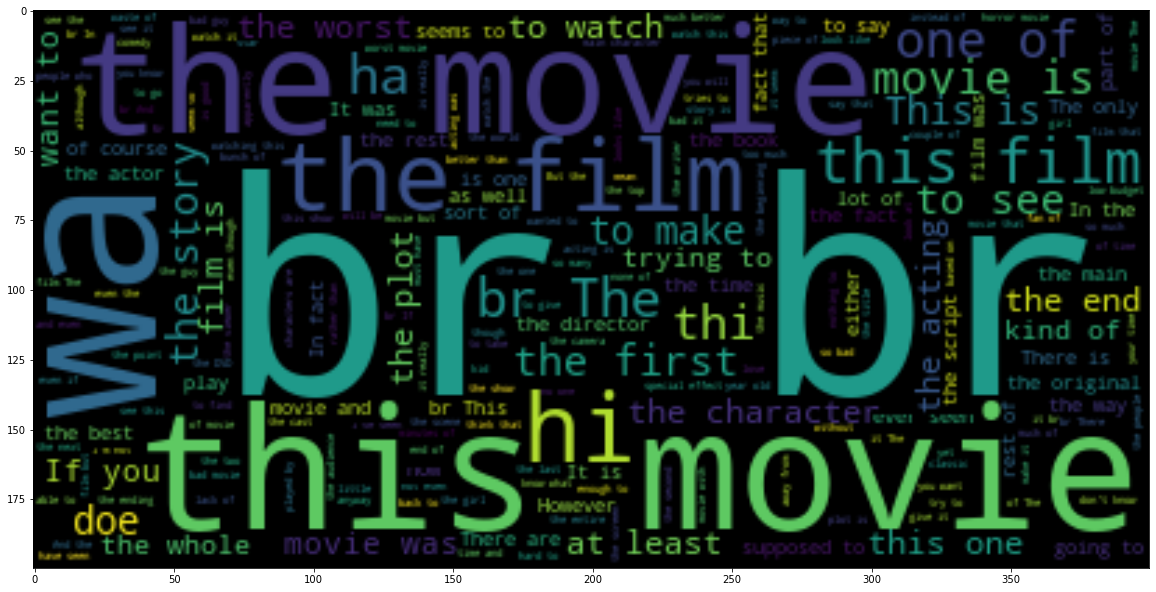

In [7]:
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000).generate(" ".join(train[train.sentiment == 0].review))
plt.imshow(wc_neg , interpolation = 'bilinear')

# TPU Configs

As using NLP-model requires power computing, using TPU is highly recommended to decrease time you spent on training models. You can check if TPU is available for you and if yes, set the distribution strategy using the following code:

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


As you can see, we used big MAX_LEN cause data contains long texts.

P.S. Also you can try LongBERT, but it's another story...

In [9]:
AUTO = tf.data.experimental.AUTOTUNE

GCS_DS_PATH = KaggleDatasets().get_gcs_path()

EPOCHS = 1
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
MAX_LEN = 384

# Modeling

In [10]:
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.metrics import f1_score

seed=47

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


**What is an ALBERT?**

[ALBERT](https://huggingface.co/albert-xxlarge-v2) is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts.


ALBERT is particular in that it shares its layers across its Transformer. Therefore, all layers have the same weights. Using repeating layers results in a small memory footprint, however, the computational cost remains similar to a BERT-like architecture with the same number of hidden layers as it has to iterate through the same number of (repeating) layers.


In [11]:
MODEL = 'albert-xxlarge-v2'

# Create tokenizer

We first tokenize all our input datasets - train&test. We will use the tokenizer for this purpose. You create a tokenizer instance using the following statement:

In [12]:
def encoding(texts, tokenizer, chunk_size=256, maxlen=512):

    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=True, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True
    )
    
    return {
        "input_ids": np.array(enc_di['input_ids']),
        "attention_mask": np.array(enc_di['attention_mask'])
    }

The **encoding** function encodes the text before feeding it to the model. Typically, it is used for getting tokens, token types, and attention masks. It outputs a dictionary of encoded text. 

In [13]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
tokenizer.save_pretrained('.')

('./spiece.model', './special_tokens_map.json', './added_tokens.json')

# Load test into memory

In [14]:
test_enc = encoding(test['review'].astype(str), tokenizer, maxlen=MAX_LEN)
    
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_enc)
    .batch(BATCH_SIZE)
    )

# Create a F1-metric

In [15]:
def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Build model

In [16]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    sequence_output = transformer({"input_ids": input_word_ids, "attention_mask": attention_mask})[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs={
        "input_ids": input_word_ids,
        "attention_mask": attention_mask}, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=[f1])
    
    return model

The build method receives an instance of a pre-trained model in its first parameter called a transformer.

In [17]:
with strategy.scope():
    transformer_layer = (
        transformers.TFAutoModel
        .from_pretrained(MODEL)
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) ((None, 384, 4096),  222595584   attention_mask[0][0]             
                                                                 input_word_ids[0][0]             
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 4096)]       0           tf_albert_model[0][0]       

# Train and validation

For training and validation, we used simple **StratifiedKFold** for Cross-Validation and got a very good correlation with public score.

**Out-of-Fold Predictions** was used as a prediction method. An out-of-fold prediction is a prediction by the model during the k-fold cross-validation procedure. That is, out-of-fold predictions are those predictions made on the holdout datasets during the resampling procedure. There will be one prediction for each example in the training dataset.

In [18]:
kfold = StratifiedKFold(n_splits=4, random_state=seed, shuffle=True)

res=[]
local_probs=pd.DataFrame()

X = train['review']
y = train['sentiment']

for i, (tdx, vdx) in enumerate(kfold.split(X, y)):
    X_train, X_valid, y_train, y_valid  = X.iloc[tdx], X.iloc[vdx], y.iloc[tdx], y.iloc[vdx]
    
    print(f"Fold {i}")

    X_train_enc = encoding(X_train.astype(str), tokenizer, maxlen=MAX_LEN)
    X_test_enc = encoding(X_valid.astype(str), tokenizer, maxlen=MAX_LEN)
    
    X_train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_train_enc, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    
    X_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test_enc, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
    )
    
    n_steps = X_train.shape[0] // BATCH_SIZE

    train_history = model.fit(
        X_train_dataset,
        steps_per_epoch=n_steps,
        verbose=True,
        validation_data=X_test_dataset,
        epochs = EPOCHS 
        )
    
    preds_oof = model.predict(test_dataset, verbose=1)
    
    local_probs['fold_%i'%i] = preds_oof.flatten()

Fold 0
157/157 [==============================] - 75s 480ms/step
Fold 1
157/157 [==============================] - 63s 404ms/step
Fold 2
157/157 [==============================] - 64s 405ms/step
Fold 3
157/157 [==============================] - 64s 405ms/step


# Create a submission

In [19]:
submission['sentiment'] = np.round(np.mean(local_probs, axis=1)).astype(int)
submission.to_csv('sub_oof.csv', index=False)

# Bonus

This is our **best solo model** which gives us great result. **To improve the result, we use ensemble.**

> Ensemble Learning performs a strategic combination of various experts or ML models in order to improve the effectiveness obtained using a single model.

**How to estimate the number of votes that is considered to be the majority?** For this we used our validation. We used the ensemble method on each fold at different values for the majority of votes and chose the optimal one.

In total, we got 15 submissions, the optimal value of the majority turned out to be 11. This helped us improve the final result!

# What didn't help us


* Data cleaning
* Fitting on all data (leads to overfit)
* Custom F1 Loss Function
* Other transformers models (RoBERTa, BERT, XLNet)

Also you can check our notebook from another NLP competition [Sibur AI](https://www.kaggle.com/imgremlin/sibur-ai-16th-place-solution) where we gained 16th place (top 4%)